# Natural Language Processing Demystified | Topic Modelling With Latent Dirichlet Allocation
https://nlpdemystified.org<br>
https://github.com/futuremojo/nlp-demystified<br><br>
Course module for this demo: https://www.nlpdemystified.org/course/topic-modelling

# spaCy upgrade and package installation.

At the time this notebook was created, spaCy had newer releases but Colab was still using version 2.x by default. So the first step is to upgrade spaCy.
<br><br>
**IMPORTANT**<br>
If you're running this in the cloud rather than a local Jupyter server on your machine, then the notebook will *timeout* after a period of inactivity. If that happens and you don't reconnect in time, you will need to upgrade spaCy again and reinstall the requisite statistical package(s).
<br><br>
Refer to this link on how to run Colab notebooks locally on your machine to avoid this issue:<br>
https://research.google.com/colaboratory/local-runtimes.html

---
> **In the course video, I ran this demo on a local Jupyter server to take advantage of multiprocessing capabilities. It's not necessary but I recommend it.**

In [ ]:
!pip install -U spacy==3.*
!python -m spacy download en_core_web_sm
!python -m spacy info

For topic modelling, we'll use **Gensim**, a popular topic modelling library originally authored by Radim Řehůřek. It has implementations for LDA and other models.<br>
https://radimrehurek.com/gensim/index.html

In [1]:
# Upgrade gensim in case.
# !pip install --upgrade numpy
!pip install -U gensim==4.*

zsh:1: no matches found: gensim==4.*


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# First pass at building an LDA topic model for our corpus

We'll use a corpus of over 90,000 CNN news articles originally compiled for training question answering models. I lightly processed them to remove some metadata and put them on Google Drive.
([original source](https://cs.nyu.edu/~kcho/DMQA/))
<br><br>
To retrieve the corpus from Google Drive, we'll use the **gdown** library which I've already installed:<br>
https://github.com/wkentaro/gdown

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# Download the CNN corpus.
!gdown 'https://drive.google.com/uc?id=122fC9XpNwFKx0ryRVKJz5MWUTzA3Vpsf'

The corpus is one large text file with each article in the corpus separated by an *@delimiter* string. We'll split the articles and place them in a list.

In [3]:
with open('/Users/justin/Documents/BBME/nlp_demystified/cnn_articles.txt', 'r', encoding='utf8') as f:
  articles = f.read().split('@delimiter')

In [4]:
print(len(articles))
print(articles[0])

92579
 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affairs program for children -- several youngsters in Kabul, Afghanistan, say they are afraid of daily violence and the frequent explosions in their war-torn country.

In response, Sedwill says: "Here in Kabul, and other big cities actually, there are very few of these bombs. The children are probably safer here than they would be in London, New York or Glasgow or many other cities.

"Most children can go about their lives in safety. It's a very family-oriented society. So it is a little bit like a city of villages," he added.

A U.N. report released earlier this year seems to contradict Sedwill's assessment.

The February report, by the special representative for children and armed confli

For this demo, we'll use a subset of the articles to speed things up but feel free to change the dataset size.

In [5]:
DATASET_SIZE = 20000
dataset = articles[:DATASET_SIZE]

Just like in the [Text Classification with Naive Bayes](https://github.com/futuremojo/nlp-demystified/blob/main/notebooks/nlpdemystified_classification_naive_bayes.ipynb) demo, we'll start off with a *blank* tokenizer with no further pipeline components to see if that's good enough.
<br><br>
We'll filter out punctuations, newlines, and any tokens containing non-alphabetic characters.

In [6]:
nlp = spacy.blank('en')

def basic_filter(tokenized_doc):
  return [t.text for t in tokenized_doc if
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

In this demo, we'll leverage spaCy's **nlp.pipe** function which can process a corpus as a batch (or a series of batches) and use multiple processes. Here, we'll process our dataset as a batch across multiple processes, then run the tokenized **doc** objects through the *basic_filter* function. You can adjust **NUM_PROCESS** as you wish.<br><br>
Take a look at these link for ways to further optimize spaCy's pipeline:<br>
https://spacy.io/usage/processing-pipelines#processing<br>
https://spacy.io/api/language#pipe<br><br>
YouTube video from spaCy on using **nlp.pipe**: [Speed up spaCy pipelines via `nlp.pipe` - spaCy shorts](https://www.youtube.com/watch?v=OoZ-H_8vRnc)<br>
Tuning **nlp.pipe**: https://stackoverflow.com/questions/65850018/processing-text-with-spacy-nlp-pipe

In [7]:
NUM_PROCESS = 4

In [8]:
%%time
tokenized_articles = list(map(basic_filter, nlp.pipe(dataset, n_process=NUM_PROCESS)))

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version 

CPU times: user 42.6 s, sys: 4.05 s, total: 46.6 s
Wall time: 55 s


In [9]:
print(tokenized_articles[0])

['Children', 'in', 'war', 'ravaged', 'Afghanistan', 'are', 'safer', 'than', 'those', 'growing', 'up', 'in', 'London', 'or', 'New', 'York', 'NATO', 'top', 'civilian', 'envoy', 'says', 'Mark', 'Sedwill', 'the', 'senior', 'civilian', 'representative', 'for', 'NATO', 'made', 'the', 'comments', 'on', 'an', 'episode', 'of', 'CBBC', 'Newsround', 'which', 'is', 'airing', 'Monday', 'In', 'the', 'show', 'a', 'BBC', 'current', 'affairs', 'program', 'for', 'children', 'several', 'youngsters', 'in', 'Kabul', 'Afghanistan', 'say', 'they', 'are', 'afraid', 'of', 'daily', 'violence', 'and', 'the', 'frequent', 'explosions', 'in', 'their', 'war', 'torn', 'country', 'In', 'response', 'Sedwill', 'says', 'Here', 'in', 'Kabul', 'and', 'other', 'big', 'cities', 'actually', 'there', 'are', 'very', 'few', 'of', 'these', 'bombs', 'The', 'children', 'are', 'probably', 'safer', 'here', 'than', 'they', 'would', 'be', 'in', 'London', 'New', 'York', 'or', 'Glasgow', 'or', 'many', 'other', 'cities', 'Most', 'children

To start off, we'll go with 20 topics. With most topic models including LDA, there isn't a clear recipe on how to pick the optimal number of topics. The nature and composition of the data (e.g. average length of each document) has a major impact on how many topics are *interpretable* by a human. Often, it's best to go with something reasonable to begin with and then try different topic numbers.<br><br>For this corpus, I'm going with 20 topics which is a small amount relative to the corpus size, but my reasoning is that since this is a general mainstream news corpus, the topics themselves are going to be fairly broad.

In [10]:
NUM_TOPICS = 20

After tokenizing our text, the first step with Gensim is to construct a **Dictionary** mapping words to integer IDs.<br>
https://radimrehurek.com/gensim/corpora/dictionary.html<br><br>
This is similar to the *fit* step we took with scikit-learn's vectorizers.

In [11]:
%%time
# Build a Dictionary of word<-->id mappings.

dictionary = corpora.Dictionary(tokenized_articles)

sample_token = 'news'
print(f'Id for \'{sample_token}\' token: {dictionary.token2id[sample_token]}')

Id for 'news' token: 1039
CPU times: user 5.56 s, sys: 183 ms, total: 5.75 s
Wall time: 5.76 s


The next step is to create a frequency bag-of-words from each article using the **dictionary**'s *doc2bow* method. This is similar to the *transform* step from scikit-learn's vectorizers.<br>
https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow

In [12]:
%%time
corpus_bow = [dictionary.doc2bow(article) for article in tokenized_articles]

CPU times: user 3.29 s, sys: 56.7 ms, total: 3.35 s
Wall time: 3.35 s


Finally, we'll generate our base LDA model. Gensim's LDA model has a large number of optional parameters but for now, we'll keep it simple.<br>
https://radimrehurek.com/gensim/models/ldamodel.html?highlight=lda#module-gensim.models.ldamodel

In [13]:
%%time
lda_model = models.LdaModel(corpus=corpus_bow, num_topics=NUM_TOPICS, id2word=dictionary, random_state=1)

CPU times: user 2min 30s, sys: 1min 26s, total: 3min 57s
Wall time: 26.7 s


Once our model is generated, we can view the topics inferred. By default, the model's *print_topics* method shows the top 20 topics and each topic's ten most significant words.<br>
https://radimrehurek.com/gensim/models/ldamodel.html?highlight=lda#gensim.models.ldamodel.LdaModel.print_topics

In [15]:
lda_model.print_topics()

[(0,
  '0.068*"the" + 0.041*"of" + 0.027*"and" + 0.025*"to" + 0.025*"in" + 0.023*"a" + 0.013*"is" + 0.009*"for" + 0.008*"that" + 0.008*"The"'),
 (1,
  '0.046*"the" + 0.031*"I" + 0.030*"a" + 0.028*"to" + 0.022*"and" + 0.019*"in" + 0.017*"of" + 0.012*"was" + 0.012*"it" + 0.012*"that"'),
 (2,
  '0.064*"the" + 0.030*"of" + 0.025*"to" + 0.023*"and" + 0.020*"in" + 0.017*"a" + 0.011*"that" + 0.011*"is" + 0.009*"Syria" + 0.008*"for"'),
 (3,
  '0.038*"the" + 0.032*"to" + 0.029*"and" + 0.029*"of" + 0.024*"a" + 0.017*"that" + 0.016*"in" + 0.013*"is" + 0.010*"are" + 0.009*"for"'),
 (4,
  '0.069*"the" + 0.030*"of" + 0.029*"to" + 0.024*"and" + 0.021*"in" + 0.019*"a" + 0.015*"said" + 0.011*"The" + 0.010*"that" + 0.009*"on"'),
 (5,
  '0.060*"the" + 0.031*"in" + 0.029*"of" + 0.028*"to" + 0.027*"and" + 0.021*"a" + 0.014*"said" + 0.011*"that" + 0.011*"The" + 0.008*"is"'),
 (6,
  '0.054*"the" + 0.033*"to" + 0.030*"of" + 0.027*"in" + 0.026*"and" + 0.025*"a" + 0.012*"said" + 0.011*"that" + 0.009*"The" + 0.0

The first pass is pretty awful. The topics are dominated by stop words such that they essentially look all the same. Let's see if we can do better.

# Improving preprocessing for better results.

For our next attempt, we'll
- remove stop words using the default spaCy stopword list. Given this is a corpus of news articles, there may be other stop words to consider such as salutations ("Mr", "Mrs"), and words related to quotes and thoughts ("say", "think"). But for this, we'll stick to defaults unless we see reason to do otherwise.
- consider only the words the spaCy tagger flags as *nouns, verbs,* and *adjectives*. Including words with only certain POS tags is a common approach to improving topic models.
- take the lemma.

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def improved_filter(tokenized_doc):
  return [t.lemma_ for t in tokenized_doc if
          t.is_alpha and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.pos_ in ['NOUN', 'VERB', 'ADJ']]

In [17]:
%%time
# We'll need to retokenize everything and rebuild the BOWs. Because we're now
# using the POS tagger, this will take longer. The "w_pos" in the variable
# names below just means "with part-of-speech".

tokenized_articles_w_pos = list(map(improved_filter, nlp.pipe(dataset, n_process=NUM_PROCESS)))
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)
corpus_bow_w_pos = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version 

CPU times: user 54 s, sys: 15 s, total: 1min 9s
Wall time: 4min 18s


In [18]:
%%time
lda_model = models.LdaModel(corpus=corpus_bow_w_pos, num_topics=NUM_TOPICS, id2word=dictionary_w_pos, random_state=1)

CPU times: user 17 s, sys: 8.1 s, total: 25.1 s
Wall time: 8.94 s


In [19]:
lda_model.print_topics()

[(0,
  '0.020*"say" + 0.012*"war" + 0.011*"attack" + 0.010*"group" + 0.010*"force" + 0.009*"kill" + 0.009*"country" + 0.009*"people" + 0.009*"military" + 0.008*"government"'),
 (1,
  '0.021*"say" + 0.012*"study" + 0.009*"cancer" + 0.008*"doctor" + 0.008*"patient" + 0.007*"year" + 0.007*"test" + 0.007*"disease" + 0.007*"find" + 0.006*"people"'),
 (2,
  '0.020*"law" + 0.016*"say" + 0.013*"right" + 0.013*"court" + 0.010*"year" + 0.010*"state" + 0.007*"gun" + 0.007*"case" + 0.007*"country" + 0.006*"immigration"'),
 (3,
  '0.042*"say" + 0.011*"military" + 0.009*"official" + 0.006*"report" + 0.006*"tell" + 0.006*"statement" + 0.005*"russian" + 0.005*"government" + 0.005*"year" + 0.004*"israeli"'),
 (4,
  '0.014*"say" + 0.009*"year" + 0.007*"new" + 0.006*"world" + 0.006*"site" + 0.006*"time" + 0.006*"design" + 0.006*"find" + 0.005*"video" + 0.005*"people"'),
 (5,
  '0.033*"say" + 0.024*"government" + 0.012*"country" + 0.012*"people" + 0.010*"report" + 0.010*"protest" + 0.008*"group" + 0.008*"

This is better but there are still a few low-signal words dominating topics such as "said" lemmatized to "say" which makes sense for a news corpus. Perhaps trimming the vocabulary and tuning the model parameters themselves can lead to something more interpretable.

# Trimming low- and high-frequency words.

One thing we can try is filtering out rare and common tokens.
https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes

In [20]:
# The size of the dictionary before filtering.
len(dictionary_w_pos)

39259

The filtering is a bit idiosyncratic. The lower bound is an *absolute* number, and the upper bound is a *percentage*. Here, we're saying filter out words which occur in fewer than N documents and more than M% of the documents.

In [21]:
dictionary_w_pos.filter_extremes(no_below=5, no_above=0.5)

In [22]:
# The size of the dictionary after filtering.
len(dictionary_w_pos)

18167

In [23]:
# Rebuild bag of words.
corpus_bow_w_pos_filtered = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

This time, we're passing additional arguments when building the model. *alpha* is the prior on the document-topic distribution, and *eta* is the prior on the topic-word distribution (this was *beta* in the slides), and *passes* is the number of complete passes through the corpus during training.<br>
https://radimrehurek.com/gensim/models/ldamodel.html?highlight=lda#module-gensim.models.ldamodel

In [24]:
%%time
lda_model = models.ldamodel.LdaModel(corpus=corpus_bow_w_pos_filtered,
                                     id2word=dictionary_w_pos,
                                     num_topics=NUM_TOPICS,
                                     passes=10,
                                     alpha='auto',
                                     eta='auto',
                                     random_state=1)

CPU times: user 1min 51s, sys: 20.7 s, total: 2min 12s
Wall time: 1min 13s


In [25]:
lda_model.print_topics()

[(0,
  '0.014*"vote" + 0.012*"president" + 0.012*"election" + 0.011*"state" + 0.010*"campaign" + 0.010*"political" + 0.009*"candidate" + 0.008*"party" + 0.007*"issue" + 0.007*"voter"'),
 (1,
  '0.041*"woman" + 0.038*"child" + 0.033*"school" + 0.025*"student" + 0.016*"girl" + 0.013*"young" + 0.012*"parent" + 0.008*"kid" + 0.008*"college" + 0.008*"education"'),
 (2,
  '0.023*"court" + 0.021*"case" + 0.021*"charge" + 0.012*"arrest" + 0.011*"attorney" + 0.010*"trial" + 0.010*"prison" + 0.010*"prosecutor" + 0.010*"crime" + 0.009*"sentence"'),
 (3,
  '0.012*"world" + 0.009*"city" + 0.008*"history" + 0.008*"today" + 0.008*"building" + 0.007*"place" + 0.007*"find" + 0.007*"century" + 0.007*"african" + 0.006*"art"'),
 (4,
  '0.014*"country" + 0.011*"russian" + 0.011*"nuclear" + 0.009*"official" + 0.009*"international" + 0.008*"military" + 0.008*"weapon" + 0.007*"talk" + 0.007*"leader" + 0.007*"world"'),
 (5,
  '0.013*"flight" + 0.013*"plane" + 0.013*"report" + 0.011*"area" + 0.010*"storm" + 0.0

With improved filtering and low- and high-frequency words trimmed, we can see the topic-word distributions containing certain themes such as crime, travel, entertainment, etc.<br><br>
**NOTE:** Remember that the topic model doesn't label topics for us. It just converges on collections of terms that likely form topics.

We set the training algorithm to learn priors for *alpha* and *eta*.

In [26]:
print(lda_model.alpha)
print(lda_model.eta)

[0.08804944 0.0930931  0.08826575 0.08708802 0.06836565 0.07706928
 0.08765173 0.03740632 0.13078636 0.06576572 0.14571157 0.08143546
 0.10287774 0.08746534 0.08284645 0.08736135 0.20974573 0.05819675
 0.07090364 0.08572964]
[0.0979354  0.05842874 0.04869653 ... 0.03962182 0.03962183 0.03962183]


The *alpha* and *eta* values the training algorithm arrived at are well below 1. This translates to most articles being dominated by one or just a few topics, and most topics being dominated by a handful of words.

We can look at the topic distribution comprising a given article using the model's *get_document_topics* method.<br>
https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.get_document_topics

In [27]:
article_idx = 0
print(dataset[article_idx][:300])

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa


In [28]:
# Return topic distribution for an article sorted by probability.
topics = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx]), key=lambda tup: tup[1])[::-1]
topics

[(19, 0.46470252),
 (1, 0.28492874),
 (8, 0.078583404),
 (10, 0.0523995),
 (9, 0.04492664),
 (17, 0.036587965),
 (15, 0.029796755)]

We can get the top words (10 by default) representing a topic using the model's *show_topic* method.
https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel.show_topic

In [33]:
# View the words of the top topic from the previous article.
lda_model.show_topic(topics[0][0])

[('attack', 0.024240559),
 ('military', 0.018667687),
 ('kill', 0.015291747),
 ('force', 0.014895065),
 ('group', 0.014072255),
 ('official', 0.0126324305),
 ('security', 0.011712122),
 ('government', 0.011016991),
 ('war', 0.010021072),
 ('report', 0.008420902)]

In [34]:
# View the words of the second-most prevalent topic from the previous article.
lda_model.show_topic(topics[1][0])

[('woman', 0.040922977),
 ('child', 0.03842351),
 ('school', 0.033227675),
 ('student', 0.02488094),
 ('girl', 0.015985867),
 ('young', 0.01262198),
 ('parent', 0.012497029),
 ('kid', 0.00848708),
 ('college', 0.007951132),
 ('education', 0.0078242095)]

The function below takes a document index and returns a **DataFrame** containing:
1. the topics comprising the document up to a minimum probability.
2. the top words of each topic.
<br>

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [35]:
def get_top_topics(article_idx, min_topic_prob):

  # Sort from highest to lowest topic probability.
  topic_prob_pairs = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx],
                                                          minimum_probability=min_topic_prob),
                            key=lambda tup: tup[1])[::-1]

  word_prob_pairs = [lda_model.show_topic(pair[0]) for pair in topic_prob_pairs]
  topic_words = [[pair[0] for pair in collection] for collection in word_prob_pairs]

  data = {
      'Major Topics': topic_prob_pairs,
      'Topic Words': topic_words
  }

  return pd.DataFrame(data)


In [36]:
pd.set_option('max_colwidth', 600)
snippet_length = 300
min_topic_prob = 0.25

article_idx = 1
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach into hotels and casinos -- but its chief executive says the brand will remain "special."

"We don't want to be in every street corner, in every city of the UK," Hard Rock's Hamish Dodds told CNN.

"We wa


,Major Topics,Topic Words
0,"(18, 0.2727229)","[food, hotel, room, good, restaurant, travel, offer, local, eat, beach]"


In [37]:
article_idx = 10
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop


,Major Topics,Topic Words
0,"(12, 0.7599919)","[government, money, pay, work, country, need, job, business, economic, plan]"


In [38]:
article_idx = 100
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres


,Major Topics,Topic Words
0,"(6, 0.36520228)","[police, officer, man, gun, shoot, kill, report, authority, find, shooting]"
1,"(2, 0.30635458)","[court, case, charge, arrest, attorney, trial, prison, prosecutor, crime, sentence]"


In [39]:
article_idx = 1000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- Desperate times call for desperate measures.

After a humbling League Cup defeat at the hands of lowly Sunderland, and with the reigning English champions a distant seventh in the Premier League table, Manchester United have broken the bank to bring in Juan Mata from Chelsea.

A club record fee


,Major Topics,Topic Words
0,"(14, 0.74366874)","[win, team, player, game, play, match, second, season, club, minute]"


In [40]:
article_idx = 10000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, 0.25)


The unspeakable terror that began with the Charlie Hebdo massacre in France again invaded the lives of ordinary citizens on Friday with separate violent standoffs that thrust a jittery nation into a new crisis.

The twin episodes -- one outside the French capital involving the suspects who shot and


,Major Topics,Topic Words
0,"(6, 0.39183754)","[police, officer, man, gun, shoot, kill, report, authority, find, shooting]"
1,"(19, 0.33488593)","[attack, military, kill, force, group, official, security, government, war, report]"


The results of this model look the best so far and we can see a human-interpretable link between the distribution of topics in a document, the distribution of words in each topic, and the content of the document itself.

# Evaluation and Visualization

## Measuring topic models with coherence.

If a topic is a mixture of particular words, then one way to measure how semantically coherent a topic is to calculate co-occurrence among the words. That is, how often the top words in a topic co-occur together among the documents versus how often they occur independently.

Gensim's **Coherence Model** offers coherence implemented as a pipeline:<br>
https://radimrehurek.com/gensim/models/coherencemodel.html
<br>
<br>
See this paper for a detailed description of the pipeline as well as different co-occurence measures proposed:<br>
http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
<br>
<br>
Topic model evaluation is a difficult subject with no clear quantitative approach and is still debated. A higher (or lower score depending on the measure) doesn't necessarily translate to a higher *qualitative* model. That is, the score a human would give looking at the topic words and how interpretable they are.<br><br>
It's possible to favour a poorer scoring model because it serves a particular purpose better. Perhaps it's better to score the effectiveness of topic models based on performance in downstream tasks? See these videos for the problems with quantitative topic model evaluation:<br>
[Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)<br>
[Is Topic Model Evaluation Broken? The Incoherence of Coherence](https://www.youtube.com/watch?v=4KO2TO_cm2I)

In [41]:
%%time
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles_w_pos, dictionary=dictionary_w_pos, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.5868956481089471
CPU times: user 2.37 s, sys: 464 ms, total: 2.83 s
Wall time: 2.88 s


## Human evaluation
Because the quantitative metrics aren't entirely correlated with quality, human judgment still plays a large role in topic model evaluation.


We can get someone to look at the topic words to see how interpretable they are.

There are also subjective tests like **word intrusion** and **topic intrusion**.
<br><br>
**Word intrusion** is taking words which belong to a topic, injecting a word from another topic into the collection, and seeing whether a human can easily identify the intruder word. The more easily the intruder word is spotted, the more well-formed the topic. For example, which word doesn't belong in this topic?<br>
*{apple, lemon, tomato, horse, grape}*

We can also visualize them with word clouds.

In [42]:
def render_word_cloud(model, rows, cols, max_words):
  word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
  fig, axes = plt.subplots(rows, cols, figsize=(15,15))

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(model.show_topic(i))
      word_cloud.generate_from_frequencies(topic_words)
      plt.gca().imshow(word_cloud, interpolation='bilinear')
      plt.gca().set_title('Topic {id}'.format(id=i))
      plt.gca().axis('off')

  plt.axis('off')
  plt.show()

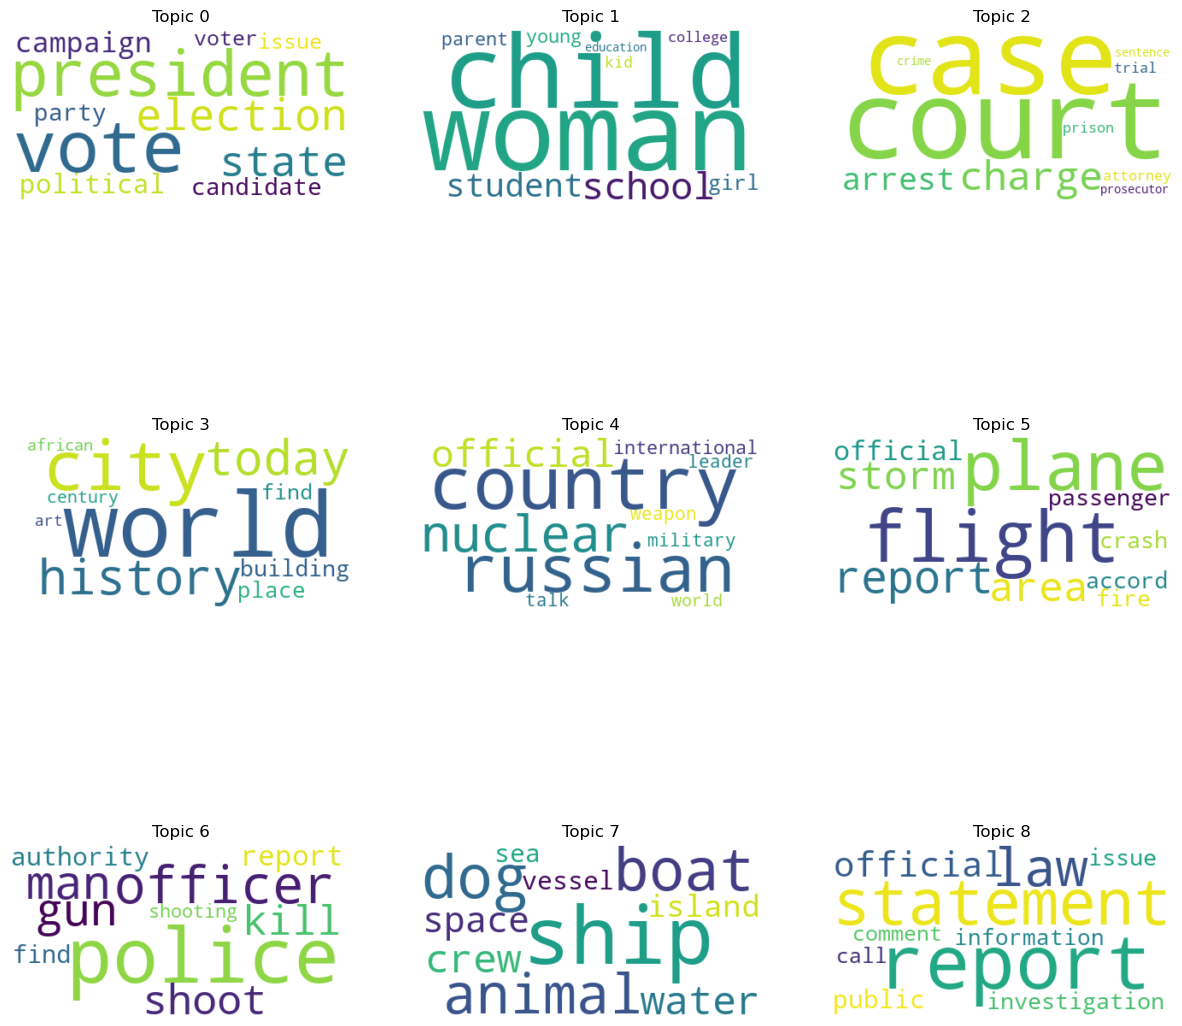

In [43]:
# Here we'll visualize the first nine topics.
render_word_cloud(lda_model, 3, 3, 10)

# Finding similar documents.

Gensim has a **similarities** module which can build an index for a given set of documents. Here, we're using **MatrixSimilarity** which computes cosine similarity across a corpus and stores them in an index.<br>
https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.MatrixSimilarity

In [44]:
lda_index = similarities.MatrixSimilarity(lda_model[corpus_bow_w_pos_filtered], num_features=len(dictionary_w_pos))

Here's a utility function to help retrieve the *first_m_words* of the *top_n* most similar documents. If you're curious about the *\_\_getitem\__* method on the LDA Model class, you can find the code here:<br>
https://github.com/RaRe-Technologies/gensim/blob/master/gensim/models/ldamodel.py

In [45]:
def get_similar_articles(index, model, article_bow, top_n=5, first_m_words=300):
  # model[article_bow] retrieves the topic distribution for the BOW.
  # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]

  # Return a list of tuples with each tuple: (article id, similarity score, first_m_words of article)
  return list(map(lambda entry: (entry[0], entry[1], articles[entry[0]][:first_m_words]), top_n_docs))

In [46]:
article_idx = 0
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa 



[(12302,
  0.9734108,
  '\nMore than 11,000 children have been killed in the nearly three-year civil war in Syria, including young boys and girls who were tortured and executed, according to a report from a London-based think tank.\n\nThe Oxford Research Group said that most of the 11,420 children reported dead were killed in '),
 (13969,
  0.9670049,
  '\nChildren as young as 10 years old increasingly face horrific abuse in war-torn Somalia as the Islamist militant group Al-Shabaab has targeted them to replenish its diminishing ranks of fighters, according to a Human Rights Watch report released Tuesday.\n\nWhile the recruitment of child soldiers by t'),
 (10064,
  0.96499866,
  '\n -- Somalia\'s Al-Shabaab has brushed aside accusations from Human Rights Watch that the Islamist militia recruits child soldiers, saying that Islam considers people to be adults from the age of 15.\n\n"The allegations from Human Rights Watch say that Al-Shabaab recruits young children at the age of 1'),
 (

In [47]:
article_idx = 10
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop 



[(6590,
  0.9976947,
  "\n -- More than one speaker at the Democratic National Convention alleged this week that a Mitt Romney presidency would spell financial ruin for Medicare in four years.\n\nThe claim stems from earlier projections, made before the Democrats' health care reform law was passed in 2010, that Medicare's hos"),
 (7271,
  0.99721503,
  '\n -- House Budget Chairman Paul Ryan, R-Wisconsin, will unveil a highly anticipated 2012 Republican budget next week that proposes dramatic changes to political lightning rods: entitlements.\n\nThe plan, to be released Tuesday, calls for a controversial overhaul of Medicare, the health care program fo'),
 (12924,
  0.9959877,
  '\n -- As the Supreme Court prepares to hear arguments in the constitutionality of the health care reform law, CNN spoke with two experts on opposing sides of the issue.\n\nKaren Harned is executive director of Small Business Legal Center for the National Federation of Independent Business. The group, a'),
 (280

In [48]:
article_idx = 100
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres 



[(18369,
  0.9739194,
  "\n -- More than 250 illegal guns have been seized by the New York City Police Department in the largest gun bust in the city's history, Mayor Michael Bloomberg announced Monday.\n\nThe guns were smuggled into New York City from North Carolina and South Carolina between September 2012 and July 2013 thro"),
 (6968,
  0.97097135,
  "\n -- An Australian businessman pleaded guilty Thursday to strapping a fake bomb around an 18-year-old girl's neck in an attempt to extort money from her family, a court representative said.\n\nThe guilty plea by Paul Douglas Peters at Sydney Central Local Court is the latest development in a case that"),
 (17704,
  0.97030824,
  '\nA West Virginia man who fatally shot four people and then himself was apparently disappointed with people in his life, including his ex-girlfriend, Monongalia County Sheriff Kenneth "Al" Kisner told CNN on Tuesday.\n\nOn Monday, Jody Lee Hunt, 39, of Westover, killed his ex, a man she was having a re'),
 (9

We can also query for documents similar to new, unseen documents. Below are short, actual blurbs from 2021 involving stock options and crime. Keep in mind that if this were a really old news corpus, then excerpts about cryptocurrencies and social media probably won't lead to good matches. This is another aspect to keep in mind when thinking about your data and use cases.

In [49]:
test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(12158,
  0.994823,
  '\n -- Almost hidden in the spectacular red rock country of northwestern New Mexico is a tiny charity that educates and houses almost 200 Native American children and their families.\n\nThe St. Bonaventure Indian Mission and School, affiliated with the Roman Catholic Diocese of Gallup, mostly survives o'),
 (12542,
  0.99266756,
  '\n -- A British parliamentary report slammed Barclays bank on Saturday for its "disgraceful" actions that led to a rate-rigging scandal.\n\nThe Treasury Select Committee issued a report after recent hearings over the scandal. Barclays was fined $450 million by British and American regulators after some'),
 (10769,
  0.99243915,
  '\n -- Nobel Laureate and microfinance pioneer Muhammad Yunus faced a new government fight Monday as the Cabinet ordered "legal action" against him for what it called "tax irregularities."\n\nThe Cabinet meeting, led by Prime Minister Sheikh Hasina, discussed a report prepared by the National Board of R'),
 (9

In [50]:
test_article = "DEA agent sentenced to 12 years in prison for conspiring with Colombian drug cartel."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(4232,
  0.99858606,
  "\n -- A former federal prosecutor was arrested Wednesday on charges related to the murder of a witness in a drug case, among many other counts, the U.S. Attorney's Office in Newark, New Jersey, said.\n\nFormer federal prosecutor Paul Bergrin is charged with leading a racketeering conspiracy that includ"),
 (6838,
  0.99837494,
  '\n -- After nearly 21 hours of deliberations, the jury in the trial of former Penn State assistant football coach Jerry Sandusky reached a verdict Friday night. It found him guilty of 45 of 48 counts.\n\nThere originally were 52 charges against Sandusky. On Thursday, Judge John Cleland announced that t'),
 (18431,
  0.9975615,
  '\nLess than a week after drug lord Rafael Caro Quintero was released from prison because of procedural errors, the Mexican government wants him locked up.\n\nThe office of the Mexican attorney general late Wednesday said that it has issued a warrant for "provisional detention," acting on a request from'),
 (85

# Closing Thoughts and things to explore.
- Gensim infers topic and word distributions through [Variational Bayes (VB)](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), not Gibbs Sampling. From the topics I've seen, Gibbs Sampling tends to lead to more interpretable topics, but VB is faster and Gensim offers the additional benefits of streaming documents, online learning, and training across a cluster of machines.
- Another topic modelling library, [Mallet](http://mallet.cs.umass.edu/), infers through Gibbs Sampling but is Java-based. Unfortunately, Gensim 4.0+ no longer offers a wrapper around Mallet. But if you're comfortable with Java, it may be worth exploring.
- Scikit-learn offers an [LDA model](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html). Maybe as an exercise, try using that LDA model on the [20 Newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) dataset (or ideally, a dataset with longer documents).
- [pyLDAvis](https://github.com/bmabey/pyLDAvis) is another means of visualizing topic models. You can see it in action in this [notebook](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb). See if you can get it working on your own topic model.
- LDA tends to work better on longer documents, and whether a topic model is "good" depends on your use case rather than strictly on a quantitative metric.